In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from scipy import io
from tensorflow.python.data import Dataset
import matplotlib.pyplot as plt
from tensorflow.python.keras import layers
from tensorflow.python.keras import models
import tensorflow_io as tfio

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [17]:
import pathlib
DATASET_PATH = "raw_data/speech_data/"

data_dir = pathlib.Path(DATASET_PATH)

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=1,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 105829 files belonging to 35 classes.
Using 84664 files for training.
Using 21165 files for validation.

label names: ['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine' 'no'
 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree'
 'two' 'up' 'visual' 'wow' 'yes' 'zero']


In [18]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [19]:
def convert_dataset(dataset):
    x_temp = []
    y_temp = []
    for wave in tqdm(dataset):
        x_temp.append(np.squeeze(wave[0], axis=0))
        label = np.zeros((3, ))
        if wave[1] == 16: #marvin
            label[1] = 1
        elif wave[1] == 24: #sheila
            label[2] = 1
        else:
            label[0] = 1
        y_temp.append(label)
    return np.array(x_temp), np.array(y_temp)

In [20]:
x_train, y_train = convert_dataset(train_ds)
x_val, y_val = convert_dataset(val_ds)

100%|██████████| 21165/21165 [01:12<00:00, 293.39it/s]


In [22]:
print(x_train.shape)
print(y_train.shape)
print(np.sum(y_train, axis=0))
print(x_val.shape)
print(y_val.shape)
print(np.sum(y_val, axis=0))

(84664, 16000)
(84664, 3)
[81378.  1671.  1615.]
(21165, 16000)
(21165, 3)
[20329.   429.   407.]


In [23]:
# normalize all data
def normalize_data(dataset):
    mean = np.mean(dataset, axis=1)
    std = np.std(dataset, axis=1)
    return ((dataset.T - mean.T) / std.T).T
x_train = normalize_data(x_train)
x_val = normalize_data(x_val)

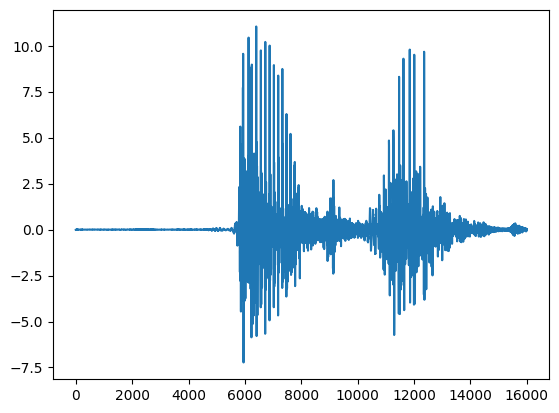

In [55]:
fig, ax = plt.subplots()
sig = x_train[0,:]
ax.plot(np.arange(sig.shape[0]), sig)
plt.show()

In [85]:
x_sheila = x_train[np.argmax(y_train, axis=1) == 2]
x_marvin = x_train[np.argmax(y_train, axis=1) == 1]
x_nontarget = x_train[np.argmax(y_train, axis=1) == 0]
print(x_marvin.shape)
print(x_sheila.shape)
print(x_nontarget.shape)

(1671, 16000)
(1615, 16000)
(81378, 16000)


In [139]:
x_sheila = x_val[np.argmax(y_val, axis=1) == 2]
x_marvin = x_val[np.argmax(y_val, axis=1) == 1]
x_nontarget = x_val[np.argmax(y_val, axis=1) == 0]
print(x_marvin.shape)
print(x_sheila.shape)
print(x_nontarget.shape)

(429, 16000)
(407, 16000)
(20329, 16000)


In [14]:
NOISE_FLOOR=0.1
from scipy import signal

def get_voice_position(audio, noise_floor):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return tfio.audio.trim(audio, axis=0, epsilon=noise_floor)

def process_audio(audio):
    voice_start, voice_end = get_voice_position(audio, NOISE_FLOOR)
    voice_start = np.array(voice_start)
    voice_end = np.array(voice_end)
    end_gap=len(audio) - voice_end
    random_offset = np.random.uniform(0, voice_start+end_gap)
    audio = np.roll(audio,int(-random_offset+end_gap))
    return audio

In [25]:
from scipy import io
dishes = io.wavfile.read('raw_data/_background_noise_/doing_the_dishes.wav')
miaow = io.wavfile.read('raw_data/_background_noise_/dude_miaowing.wav')
bike = io.wavfile.read('raw_data/_background_noise_/exercise_bike.wav')
pink = io.wavfile.read('raw_data/_background_noise_/pink_noise.wav')
tap = io.wavfile.read('raw_data/_background_noise_/running_tap.wav')
white = io.wavfile.read('raw_data/_background_noise_/white_noise.wav')
domain_noise = io.wavfile.read("augmented_data/background_noise.wav")
background_list = [dishes, miaow, bike, pink, tap, white, domain_noise]

C:\Users\thoma\AppData\Local\Temp\ipykernel_30592\2906035967.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  dishes = io.wavfile.read('raw_data/_background_noise_/doing_the_dishes.wav')
C:\Users\thoma\AppData\Local\Temp\ipykernel_30592\2906035967.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  miaow = io.wavfile.read('raw_data/_background_noise_/dude_miaowing.wav')
C:\Users\thoma\AppData\Local\Temp\ipykernel_30592\2906035967.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  bike = io.wavfile.read('raw_data/_background_noise_/exercise_bike.wav')
C:\Users\thoma\AppData\Local\Temp\ipykernel_30592\2906035967.py:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  tap = io.wavfile.read('raw_data/_background_noise_/running_tap.wav')
C:\Users\thoma\AppData\Local\Temp\ipykernel_30592\2906035967.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  domain_noise = io.wavfile.read("augmented_data/backgro

In [24]:
NOISE_FLOOR=0.1
from scipy import signal

def get_voice_position(audio, noise_floor):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return tfio.audio.trim(audio, axis=0, epsilon=noise_floor)

def process_audio(audio):
    # mean = np.mean(audio)
    # std = np.std(audio)
    # audio = np.mean
    voice_start, voice_end = get_voice_position(audio, NOISE_FLOOR)
    voice_start = np.array(voice_start)
    voice_end = np.array(voice_end)
    end_gap=len(audio) - voice_end
    random_offset = np.random.uniform(0, voice_start+end_gap)
    audio = np.roll(audio,int(-random_offset+end_gap))
    background_volume = np.random.uniform(0.0, 0.5)
    # get the background noise files
    background_index = np.random.choice(np.arange(0, len(background_list)))
    background_tensor = background_list[background_index][1]
    rate = 0
    if background_index == 6:
        rate = 44100
    else:
        rate = 16000
    background_start = np.random.randint(0, len(background_tensor) - rate)
    # normalise the background noise
    temp_back = background_tensor[background_start:background_start+rate]
    background = np.array(temp_back, np.float32)
    background = signal.resample(background, 16000)
    # background = np.squeeze(background, axis=1)
    mean = np.mean(background)
    std = np.std(background)
    background = (background - mean) / std
    # mix the audio with the scaled background
    audio = audio + (background_volume * background)
    audio = signal.resample(audio, 8000)
    return audio

def random_background():
    # get the background noise files
    background_index = np.random.choice(np.arange(0, len(background_list)))
    background_tensor = background_list[background_index][1]
    rate = 0
    if background_index == 6:
        rate = 44100
    else:
        rate = 16000
    background_start = np.random.randint(0, len(background_tensor) - rate)
    # normalise the background noise
    background = background_tensor[background_start:background_start+rate]
    background = np.array(background, np.float32)
    background = signal.resample(background, 16000)
    # background = np.squeeze(background, axis=1)
    mean = np.mean(background)
    std = np.std(background)
    background = (background - mean) / std
    background = signal.resample(background, 8000)
    return background

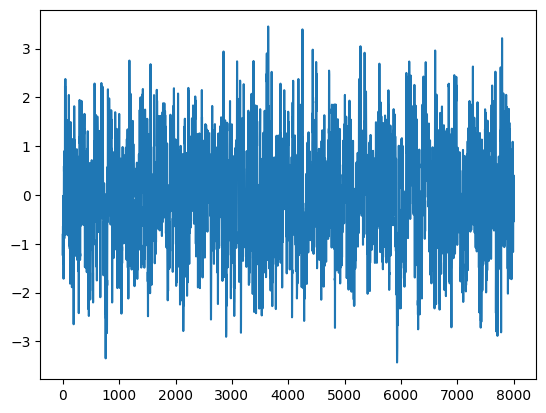

In [97]:
fig, ax = plt.subplots()
audio_original = random_background().astype(np.float32)

ax.plot(np.arange(audio_original.shape[0]), audio_original)
spectrogram = tf.signal.stft(
      audio_original, frame_length=255, frame_step=128)
spectrogram = tf.abs(spectrogram)
spectrogram = tf.math.log(spectrogram).numpy()
plt.show()

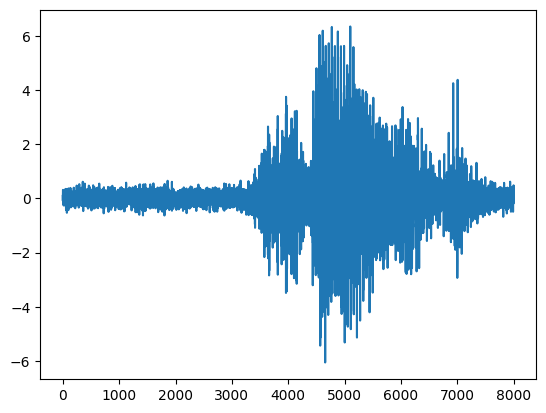

In [82]:
sig = process_audio(x_sheila[7,:])
fig, ax = plt.subplots()
ax.plot(np.arange(sig.shape[0]), sig)
plt.show()
from IPython import display
display.display(display.Audio(sig, rate=8000))

In [84]:
def augment_dataset(dataset, amount):
    x_temp = []
    for original in tqdm(dataset):
        for i in range(amount):
            x_temp.append(process_audio(original))
    return np.array(x_temp)

def augment_dataset_random(dataset, amount):
    x_temp = []
    for i in tqdm(range(amount)):
        index = np.random.randint(0, dataset.shape[0])
        x_temp.append(process_audio(dataset[index,:]))
    return np.array(x_temp)

In [147]:
x_marvin = augment_dataset(x_marvin, 50)

100%|██████████| 429/429 [02:05<00:00,  3.42it/s]


In [148]:
print(x_marvin.shape)

(21450, 8000)


In [149]:
np.savez("augmented_data/val/marvin_custom.npz", data=x_marvin)

In [146]:
print(x_marvin.shape)

(429, 16000)


In [143]:
x_sheila = augment_dataset(x_sheila, 50)

100%|██████████| 407/407 [01:51<00:00,  3.65it/s]


In [144]:
np.savez("augmented_data/val/sheila_custom.npz", data=x_sheila)

In [99]:
print(x_marvin.shape)
print(x_sheila.shape)

(83550, 8000)
(80750, 8000)


In [141]:
x_nontarget = augment_dataset(x_nontarget, 1)
print(x_nontarget.shape)

100%|██████████| 20329/20329 [01:43<00:00, 197.14it/s]


(20329, 8000)


In [142]:
# np.savez("augmented_data/train/marvin_noise", data=x_marvin)
# np.savez("augmented_data/val/sheila_noise", data=x_sheila)
np.savez("augmented_data/val/nontarget_noise_custom", data=x_nontarget)

In [9]:
from scipy import fft
from tensorflow.python.ops.signal import fft_ops
from scipy import signal
# window = signal.windows.hann(255)
# print(window.shape)
# print(window)
# print(np.max(window))
# print(window[127])
EPSILON = 1e-6
def custom_spetrogram(wav_sig, frame_length, frame_step):
    fft_window = 1
    while(fft_window < frame_length):
        fft_window *= 2
    window = signal.windows.hann(frame_length)
    temp = []
    for i in range(0, len(wav_sig) - frame_length + 1, frame_step):
        # print(i, i + frame_size + 1)
        # temp.append(wav_sig[i:i + frame_size + 1])
        wav = np.zeros((fft_window + 1,))
        temp_wav_sig = wav_sig[i:i + fft_window + 1]
        for j in range(0, frame_length):
            wav[j] = temp_wav_sig[j]  * window[j]
        for j in range(frame_length, fft_window):
            wav[j] = 0
        # # print(wav.shape)
        # wav[-1] = 0
        # print(wav[i:i + frame_size].shape)
        # wav[i:i + frame_size] = wav[i:i + frame_size] * window
        # # print(wav.shape)
        short_spec = fft.rfft(wav)
        # print(short_spec.real.shape)
        temp.append((short_spec.real **2 + short_spec.imag **2)[:int(fft_window / 2) + 1])
    temp = np.array(temp)
    # print(temp.shape)
    return temp

In [10]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = custom_spetrogram(
      waveform, frame_length=128, frame_step=160)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram).numpy()
  # spectrogram = np.log(spectrogram) + EPSILON
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [5]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [5]:
from numba import cuda 
device = cuda.get_current_device()
device.reset()

(50, 65, 1)


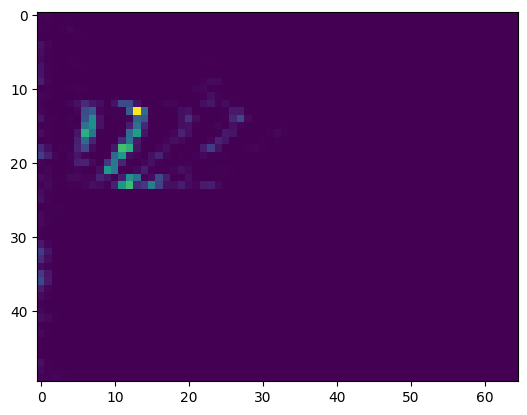

In [14]:
spec = get_spectrogram(x_sheila[55,:])
print(spec.shape)
fig, ax = plt.subplots()
ax.imshow(spec)
plt.show()

In [11]:
def convert_to_spectrogram(dataset):
    x_temp = []
    for sig in tqdm(dataset):
        x_temp.append(get_spectrogram(sig))
    return np.array(x_temp)

In [22]:
def generate_noise_data(amount):
    x_temp = []
    for i in tqdm(range(amount)):
        audio_original = random_background().astype(np.float32)
        spectrogram = custom_spetrogram(audio_original, frame_length=128, frame_step=160)
        spectrogram = tf.abs(spectrogram).numpy()
        # spectrogram = np.log(spectrogram) + EPSILON
        spectrogram = spectrogram[..., tf.newaxis]
        x_temp.append(spectrogram)
    return np.array(x_temp)

In [28]:
x_noise = generate_noise_data(20000)

100%|██████████| 20000/20000 [00:42<00:00, 466.49it/s]


In [29]:
np.savez("augmented_data/val/noise_custom_spec", data=x_noise)

In [30]:
x_marvin = np.load("augmented_data/val/marvin_custom.npz")["data"]
x_marvin = convert_to_spectrogram(x_marvin)
print(x_marvin.shape)

100%|██████████| 21450/21450 [00:37<00:00, 574.95it/s]


(21450, 50, 65, 1)


In [31]:
np.savez("augmented_data/val/marvin_custom_spec", data=x_marvin)

In [32]:
x_sheila = np.load("augmented_data/val/sheila_custom.npz")["data"]
# x_sheila = signal.resample(x_sheila, 8000, axis=1)
print(x_sheila.shape)
x_sheila = convert_to_spectrogram(x_sheila)
print(x_sheila.shape)

(20350, 8000)


100%|██████████| 20350/20350 [00:35<00:00, 570.80it/s]


(20350, 50, 65, 1)


In [33]:
np.savez("augmented_data/val/sheila_custom_spec", data=x_sheila)

In [37]:
x_nontarget = np.load("augmented_data/val/nontarget_noise_custom.npz")["data"]
x_nontarget = convert_to_spectrogram(x_nontarget)
print(x_nontarget.shape)

100%|██████████| 20329/20329 [00:36<00:00, 551.42it/s]


(20329, 50, 65, 1)


In [36]:
np.savez("augmented_data/val/nontarget_custom_spec", data=x_nontarget)